<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Graphs For Data Science</h1>
<h1>Weighted Directed Graphs</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import tqdm as tq
from tqdm.notebook import tqdm
tqdm.pandas()
import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 8.12.2

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 22.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: f30e3a3a31830759057f02a93e62e5bc250fa517

matplotlib: 3.7.1
pandas    : 1.5.3
tqdm      : 4.62.0
json      : 2.0.9
cartopy   : 0.21.1
numpy     : 1.24.2
watermark : 2.1.0



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Flight Data

We start by loading up the data from the "T-100 Domestic Segment (U.S. Carriers)" file covering the entire year of 2019 that we downloaded from [BTS](https://www.transtats.bts.gov/Tables.asp?DB_ID=110&DB_Name=Air%20Carrier%20Statistics%20(Form%2041%20Traffic)-%20%20U.S.%20Carriers). The online database allows you to select many fields, but we'll use just a few.

In [4]:
flights = pd.read_csv('data/336781026_T_T100D_SEGMENT_US_CARRIER_ONLY.zip',
                     usecols=['ORIGIN', 'DEST', 'PASSENGERS'], 
                     dtype={'ORIGIN':'str', 'DEST': 'str', 'PASSENGERS':'int'})

This file contains a row for each individual flight. In total we have:

In [5]:
flights.shape

(391114, 3)

We aggregate across all the flights connecting the same _ORIGIN_ and _DEST_

In [6]:
edges = flights.groupby(['ORIGIN', 'DEST'], as_index=False).sum()

In the end we have about 27,300 edges

In [7]:
edges.shape

(27302, 3)

The Top 5 edges, by number of passengers, are:

In [8]:
edges.sort_values('PASSENGERS', ascending=False).head()

,ORIGIN,DEST,PASSENGERS
13793,LAX,JFK,1809470
12539,JFK,LAX,1787136
13871,LAX,SFO,1779744
23302,SFO,LAX,1754685
13595,LAS,LAX,1600617


We can also check how many self-loops we have

In [9]:
edges[edges['ORIGIN'] == edges['DEST']].sort_values('PASSENGERS', ascending=False)

,ORIGIN,DEST,PASSENGERS
9400,GCN,GCN,41012
2982,BLD,BLD,22881
19516,PGA,PGA,22466
14527,LKE,LKE,9876
15,1G4,1G4,3101
...,...,...,...
11877,ILI,ILI,0
11840,IGM,IGM,0
10628,HOU,HOU,0
10499,HNL,HNL,0


We remove these

In [10]:
edges = edges[edges['ORIGIN'] != edges['DEST']].copy()

In [11]:
edges.shape

(27072, 3)

We can extract the complete list of airport codes by combining the _ORIGIN_ and _DEST_ sets

In [12]:
nodes = set(edges['ORIGIN'].unique()) | set (edges['DEST'].unique())

And we have over 1300 unique airports!

In [13]:
len(nodes)

1318

# Airport Data

We load the airport information from the 'Master Coordinate' dataset downloaded from [BTS](https://www.transtats.bts.gov/Tables.asp?DB_ID=595&DB_Name=Aviation%20Support%20Tables&DB_Short_Name=Aviation%20Support%20Tables). Here we are only interested in 4 fields

In [14]:
airports = pd.read_csv('data/336781026_T_MASTER_CORD.zip', 
                       usecols=['AIRPORT', 'LATITUDE', 'LONGITUDE', 'AIRPORT_IS_LATEST'])

The _AIRPORT_IS_LATEST_ field represents the most recent coordinates for a given airport (coordinates can change when airports move to a new location in order to expand). We make sure to pick always the most recent coordinates

In [15]:
airports.set_index('AIRPORT').loc['JFK']

,LATITUDE,LONGITUDE,AIRPORT_IS_LATEST
AIRPORT,,,
JFK,40.638611,-73.776944,0
JFK,40.639722,-73.778889,0
JFK,40.640000,-73.778611,0
JFK,40.639722,-73.778889,0
JFK,40.640000,-73.778611,1


We filter out just the most recent set of coordinates

In [17]:
def get_latest(x):
    return x.sort_values('AIRPORT_IS_LATEST').drop(columns=['AIRPORT']).iloc[-1]

In [18]:
airports = airports.groupby('AIRPORT').progress_apply(get_latest)

  0%|          | 0/6572 [00:00<?, ?it/s]

So we have over 6,500 airports as the BTS database includes airports all over the world. 

In [19]:
airports.shape

(6572, 3)

And now we can safely drop the extraneous column

In [20]:
airports.drop(columns=['AIRPORT_IS_LATEST'], inplace=True)

Here we select the airports within the US and corresponding to the flights for which we have information

In [21]:
airports = airports.loc[nodes]

In [23]:
airports.shape

(1318, 2)

And obtain a DataFrame with just the Lat and Long coordinates for each of the airports we are interesteed in

In [24]:
airports.head()

,LATITUDE,LONGITUDE
AIRPORT,,
ACV,40.977778,-124.108333
MTX,64.806667,-147.762500
HIK,21.317778,-157.920278
GDV,47.138611,-104.807222
NV5,40.757500,-119.215833


For simplicity we will focus only on the airports located within the contiguos 48 states

In [25]:
airports48 = airports[(airports.LONGITUDE>=-124.848974) & (airports.LONGITUDE<=-66.885444) & 
                      (airports.LATITUDE>=  24.396308) & (airports.LATITUDE<=  49.384358)].copy()

In [26]:
airports48.shape

(962, 2)

# Draw the network

We now combine the airport coordinates with the flight information

In [27]:
edges48 = edges.merge(airports48, left_on='ORIGIN', right_index=True, how='inner').merge(airports48, 
            left_on='DEST', right_index=True, suffixes=('_ORIGIN', '_DEST'), how='inner')

In [28]:
edges48.shape

(22691, 7)

# Network Statistics

Now that we fully defined out network, we can start to measure a few interesting statistics. A common way to characterize a node is by the number of incoming or outgoing connections it has, $k_{in}$ and $k_{out}$, respectively

In [30]:
degrees_out = edges48[['ORIGIN', 'DEST']].groupby('ORIGIN').count()
degrees_in = edges48[['ORIGIN', 'DEST']].groupby('DEST').count()

We build a DataFrame with both in/out degrees

In [31]:
in_out = degrees_in.join(degrees_out, how='outer').fillna(0)
in_out.columns = ['kin', 'kout']
in_out = in_out.astype('int')

In [33]:
in_out

,kin,kout
1B1,2,4
1CA,1,1
1G4,5,7
1GA,1,1
1TX,1,1
...,...,...
YNG,12,12
YUM,22,17
ZXB,1,1
ZXC,1,0


In [34]:
in_out.describe()

,kin,kout
count,960.000000,960.000000
mean,23.636458,23.636458
std,39.696163,41.226303
min,0.000000,0.000000
25%,2.000000,2.000000
50%,5.000000,5.000000
75%,24.000000,23.000000
max,231.000000,249.000000


Surprisingly, we find that there are nodes with 0 in/out degree! Airports from where flights leave but none arrive, or vice versa. There's 60 such airports

In [35]:
in_out[(in_out['kout'] == 0) | (in_out['kin'] == 0)].shape

(60, 2)

The airports with the highest degrees are:

In [31]:
in_out.sort_values('kout', ascending=False).head()

,kin,kout
ORD,231,249
DFW,222,233
DEN,217,232
ATL,215,217
MSP,189,213


Correlation between in and out degree

Text(0, 0.5, '$k_{in}$')

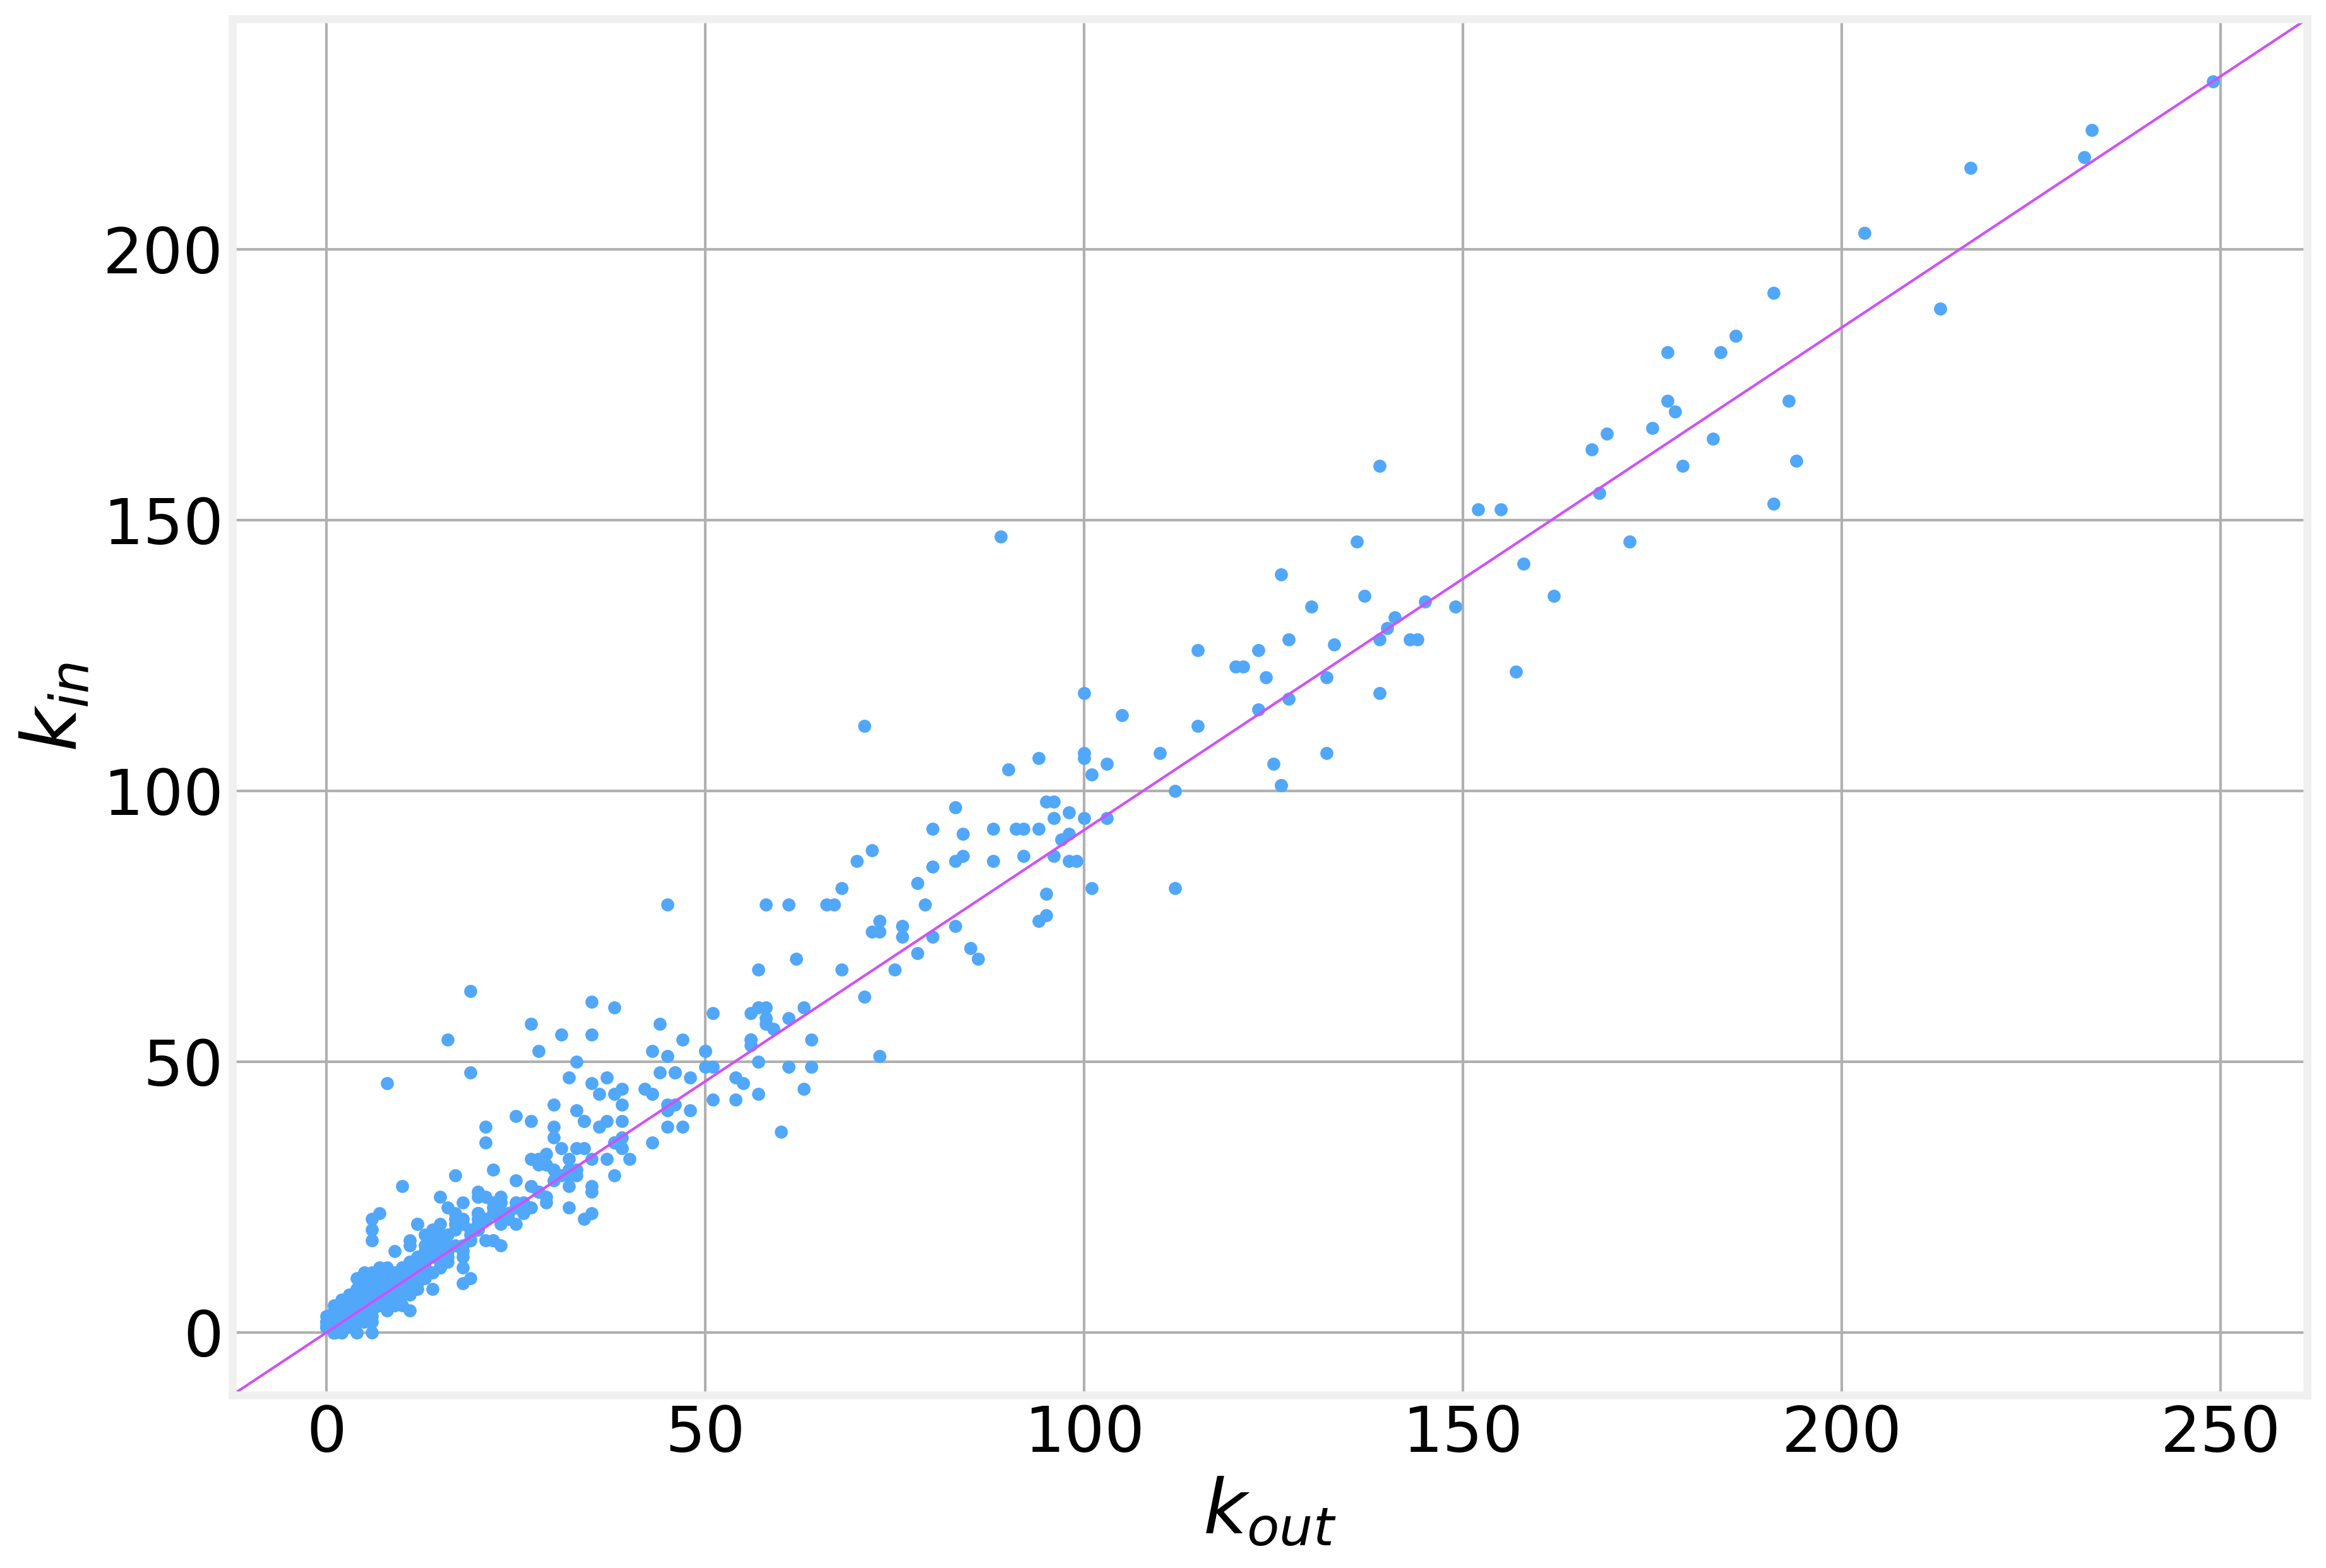

In [36]:
ax = in_out.plot.scatter(x='kout', y='kin')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=1, color=colors[1])
ax.set_xlabel('$k_{out}$')
ax.set_ylabel('$k_{in}$')

In [37]:
in_out.corr()

,kin,kout
kin,1.000000,0.986171
kout,0.986171,1.000000


The degree distributions are

In [38]:
PKin = pd.DataFrame(Counter(in_out['kin']).items(), columns=['kin', 'Pkin']).sort_values('kin')
PKout = pd.DataFrame(Counter(in_out['kout']).items(), columns=['kout', 'Pkout']).sort_values('kout')

In [39]:
PKin['Pkin'] /= PKin['Pkin'].sum()
PKout['Pkout'] /= PKout['Pkout'].sum()

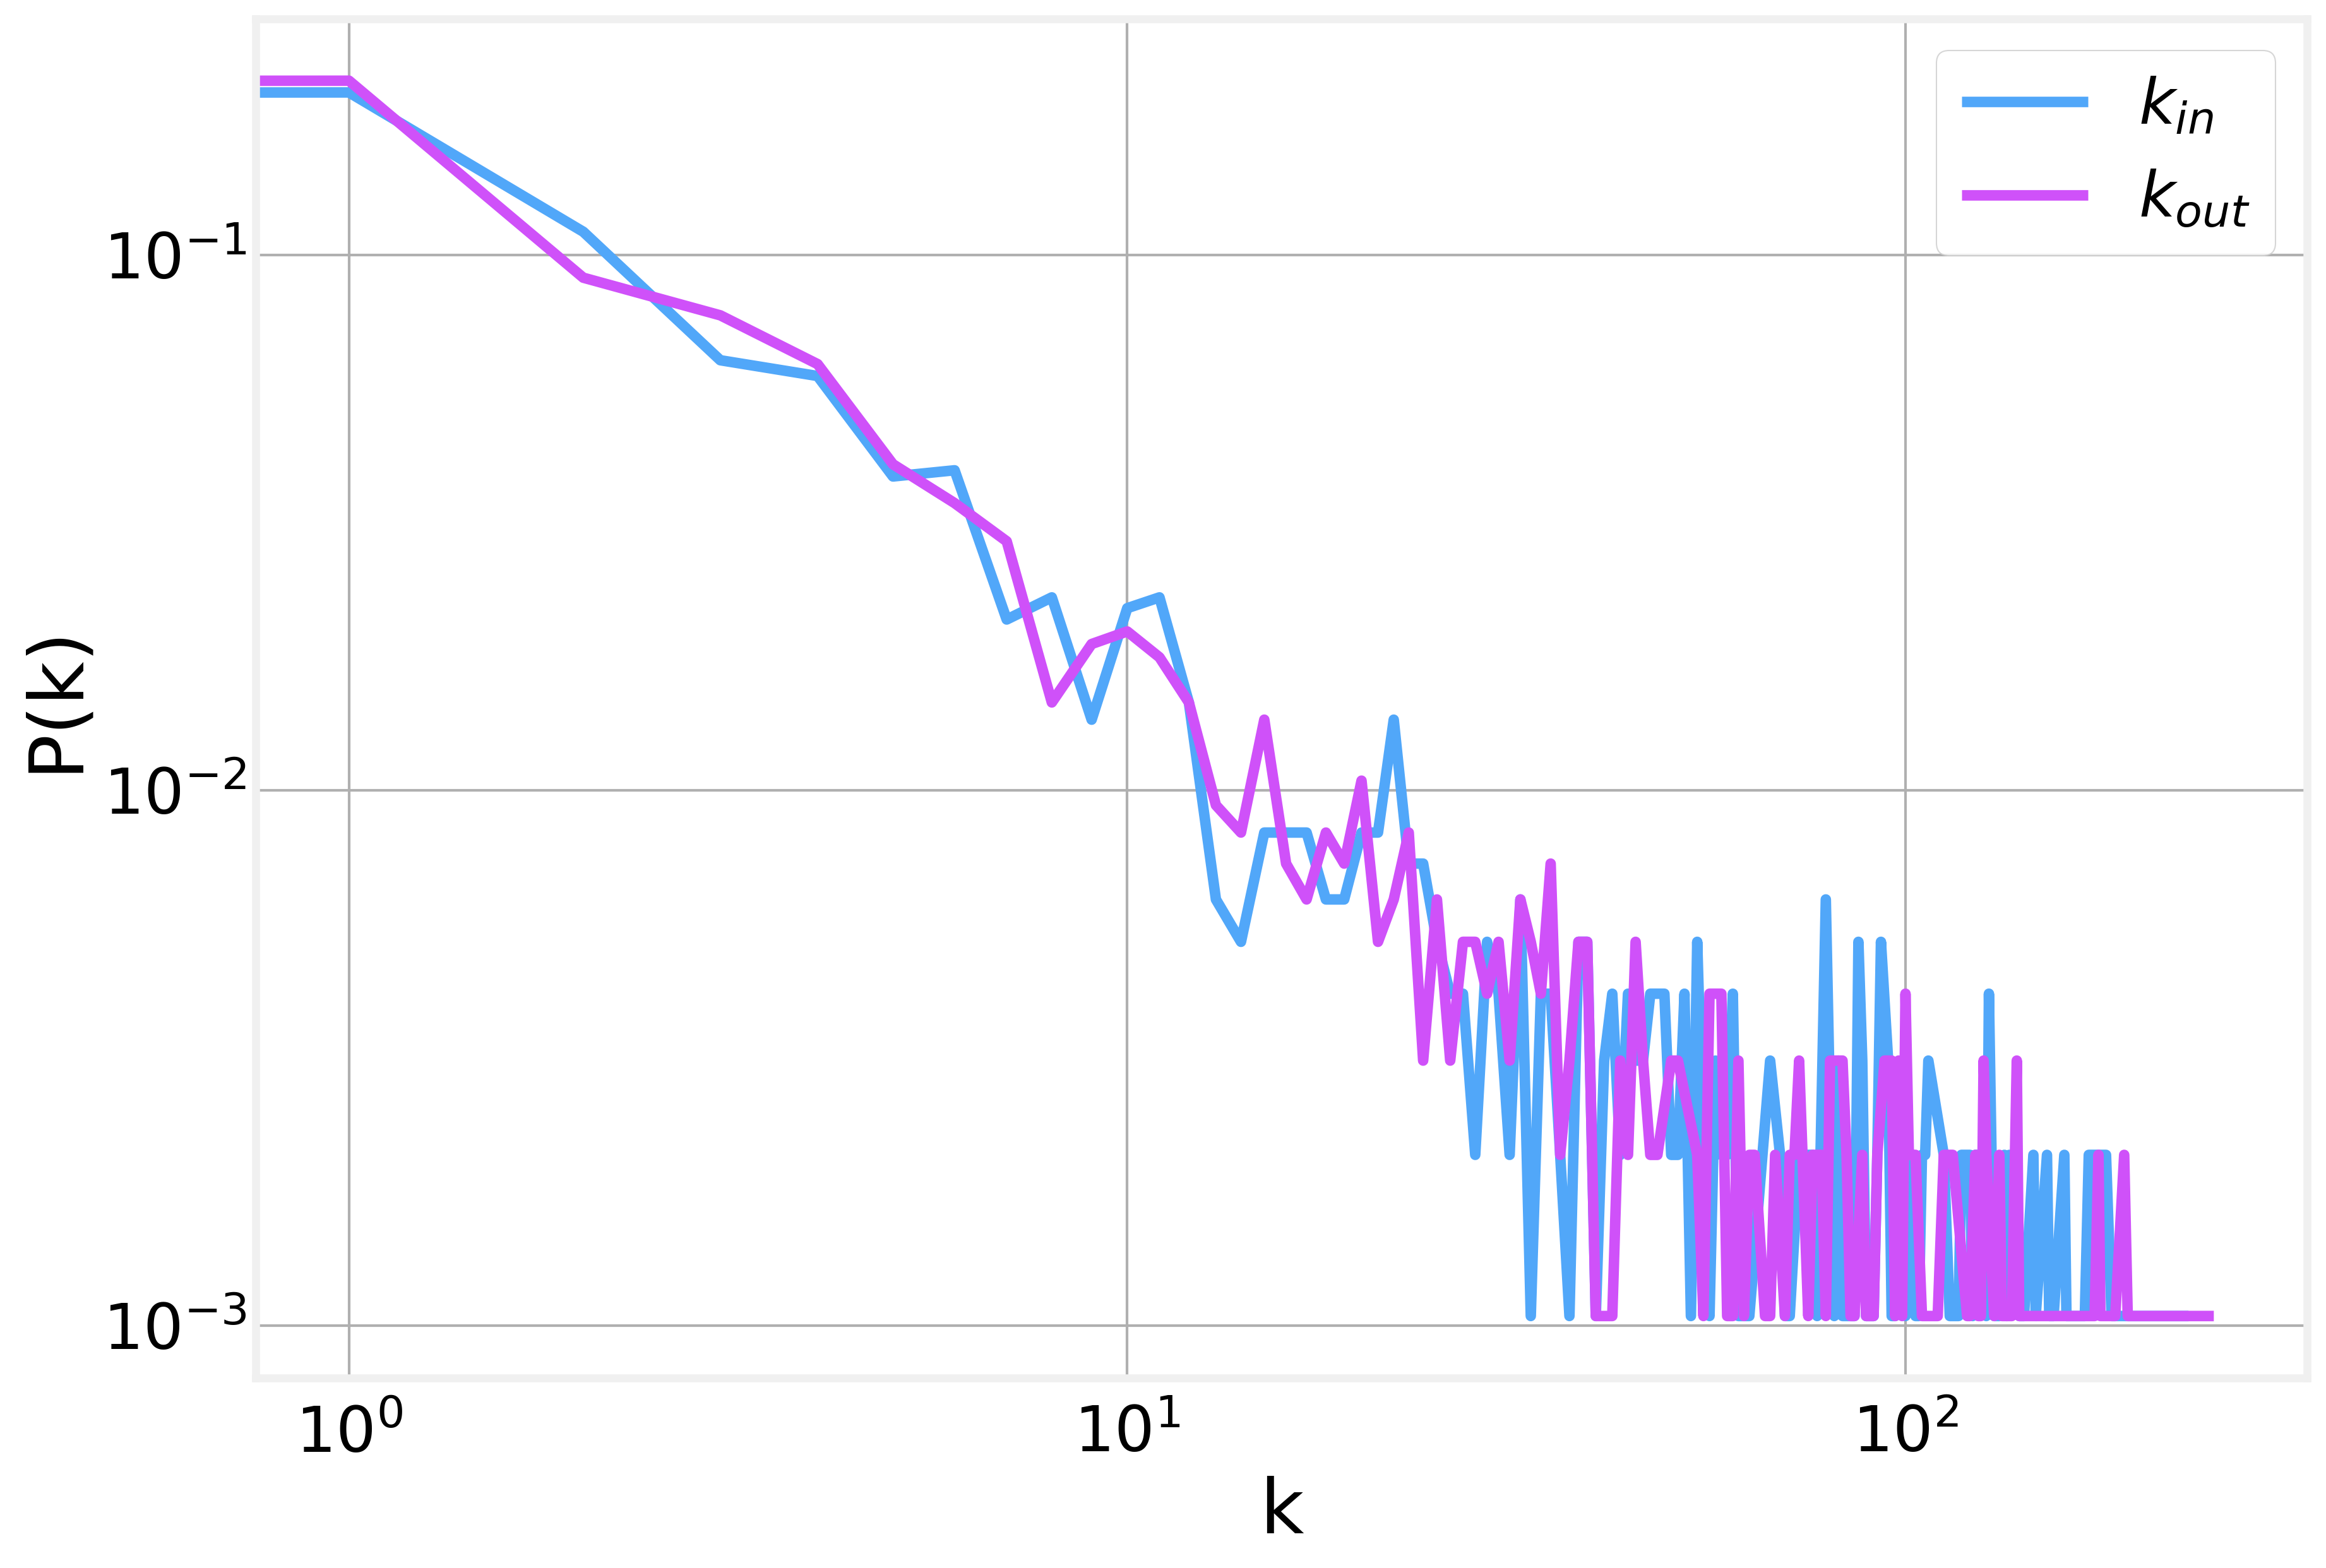

In [40]:
ax = PKin.plot(x='kin', y='Pkin')
PKout.plot(x='kout', y='Pkout', ax=ax)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('k')
ax.set_ylabel('P(k)')
ax.legend(['$k_{in}$', '$k_{out}$'])
ax.tick_params(axis='x', which='major', pad=10)
plt.tight_layout()

# Weight Distribution

As we saw, each edge also has a weight associated with it. Namely, the number of passengers travelling between the two airports

In [41]:
edges48

,ORIGIN,DEST,PASSENGERS,LATITUDE_ORIGIN,LONGITUDE_ORIGIN,LATITUDE_DEST,LONGITUDE_DEST
10,1B1,ACK,2,42.291389,-73.710278,41.253056,-70.060000
877,ALB,ACK,3,42.749167,-73.801944,41.253056,-70.060000
1763,AUG,ACK,2,44.320556,-69.797222,41.253056,-70.060000
2123,BBX,ACK,4,40.137500,-75.265278,41.253056,-70.060000
2153,BDL,ACK,69,41.939167,-72.683333,41.253056,-70.060000
...,...,...,...,...,...,...,...
26538,VNY,LVS,1,34.209722,-118.490000,35.654167,-105.142500
26576,VNY,RVS,3,34.209722,-118.490000,36.039444,-95.984722
27105,YIP,BVO,0,42.240000,-83.530833,36.763333,-96.011111
27190,YIP,OLM,2,42.240000,-83.530833,46.969444,-122.902500


We compute the weight distribution across all edges

In [42]:
PW = pd.DataFrame(Counter(((edges48['PASSENGERS']/1000).round()+1)*1000).items(), columns=['w', 'Pw']).sort_values('w')
PW = PW[PW>0] # Remove the count for edges with zero weight

And plot it. 

Text(0, 0.5, 'P(w)')

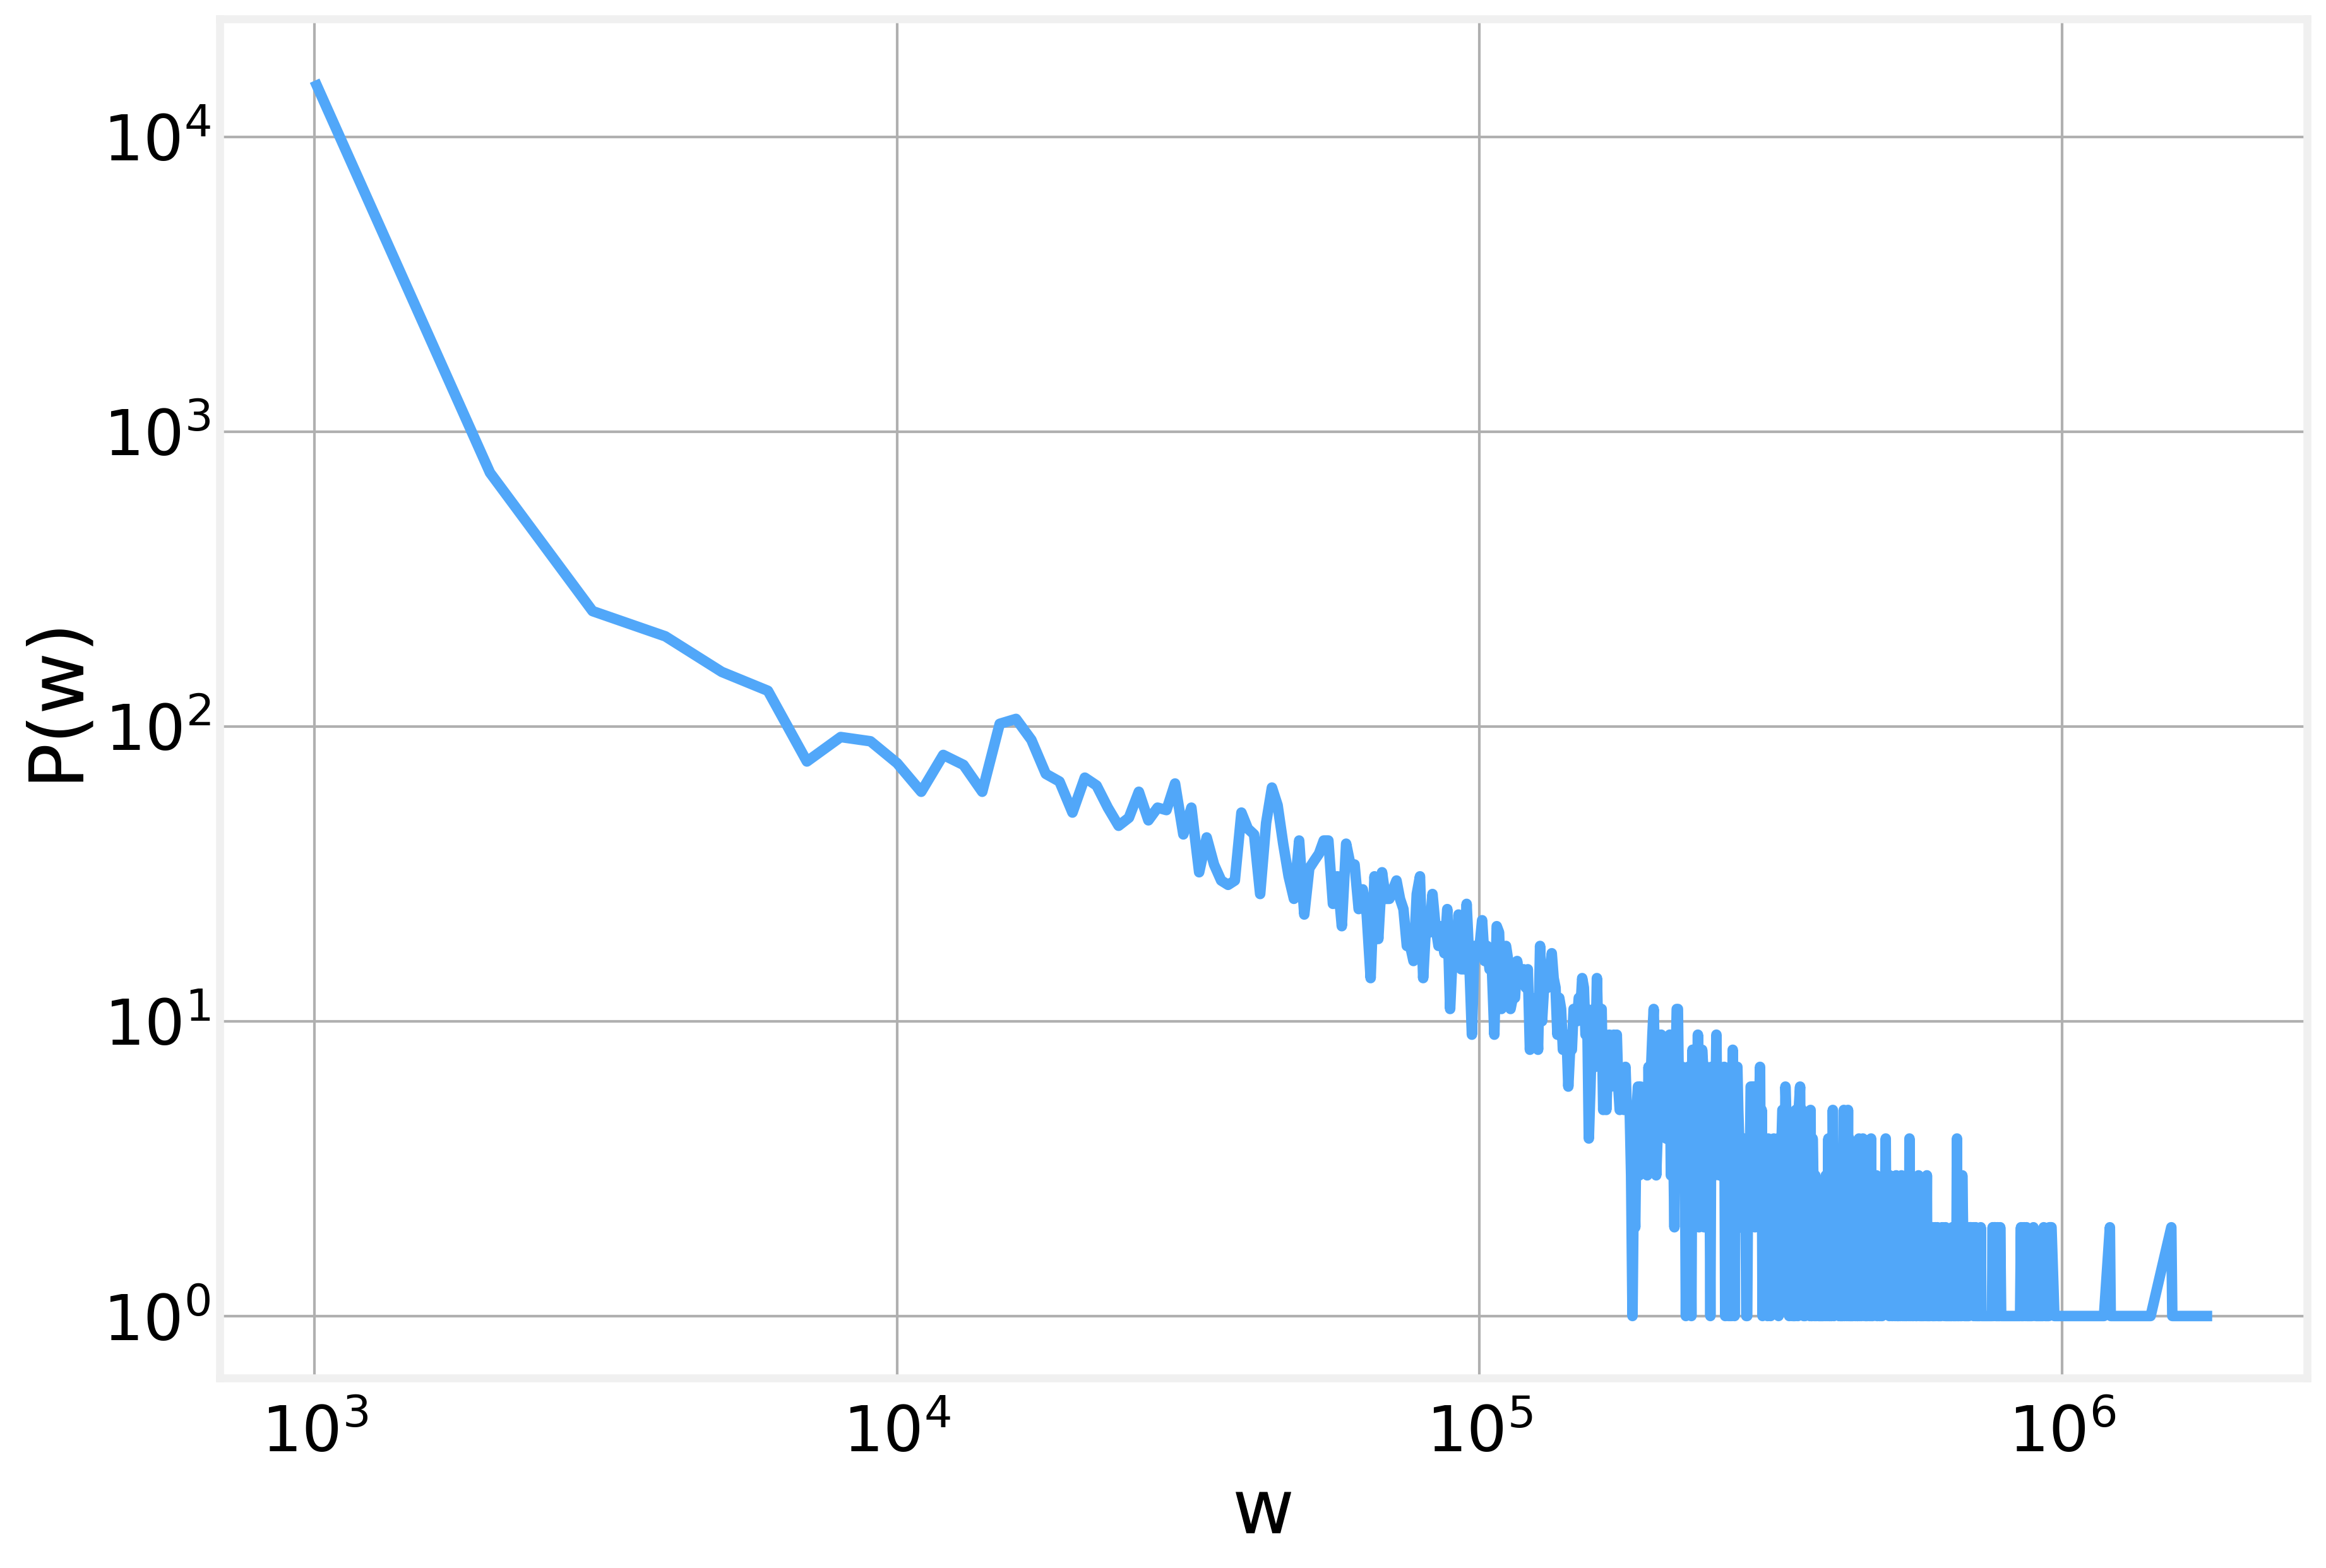

In [43]:
ax = PW.set_index('w').plot(legend=None)
ax.tick_params(axis='x', which='major', pad=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('w')
ax.set_ylabel('P(w)')

The distribution is broadtailed as expected

# Strength

The weighted equivalent of the degree is the stregth

In [44]:
stregth_out = edges48[['ORIGIN', 'PASSENGERS']].groupby('ORIGIN').sum()
stregth_in = edges48[['DEST', 'PASSENGERS']].groupby('DEST').sum()

In [45]:
in_out = in_out.join(stregth_in, how='outer', lsuffix='_l').fillna(0)
in_out = in_out.join(stregth_out, how='outer', rsuffix='_r').fillna(0)
in_out.columns = ['kin', 'kout', 'sin', 'sout']

In [46]:
in_out

,kin,kout,sin,sout
1B1,2,4,7.0,14.0
1CA,1,1,8.0,8.0
1G4,5,7,15176.0,15100.0
1GA,1,1,1.0,0.0
1TX,1,1,1.0,1.0
...,...,...,...,...
YNG,12,12,1387.0,1390.0
YUM,22,17,95579.0,98355.0
ZXB,1,1,0.0,0.0
ZXC,1,0,0.0,0.0


In [47]:
PSin = pd.DataFrame(Counter(((in_out['sin']/1000).round()+1)*1000).items(), columns=['sin', 'Psin']).sort_values('sin').set_index('sin')
PSout = pd.DataFrame(Counter(((in_out['sout']/1000).round()+1)*1000).items(), columns=['sout', 'Psout']).sort_values('sout').set_index('sout')

In [48]:
PSin /= PSin.sum()
PSout /= PSout.sum()

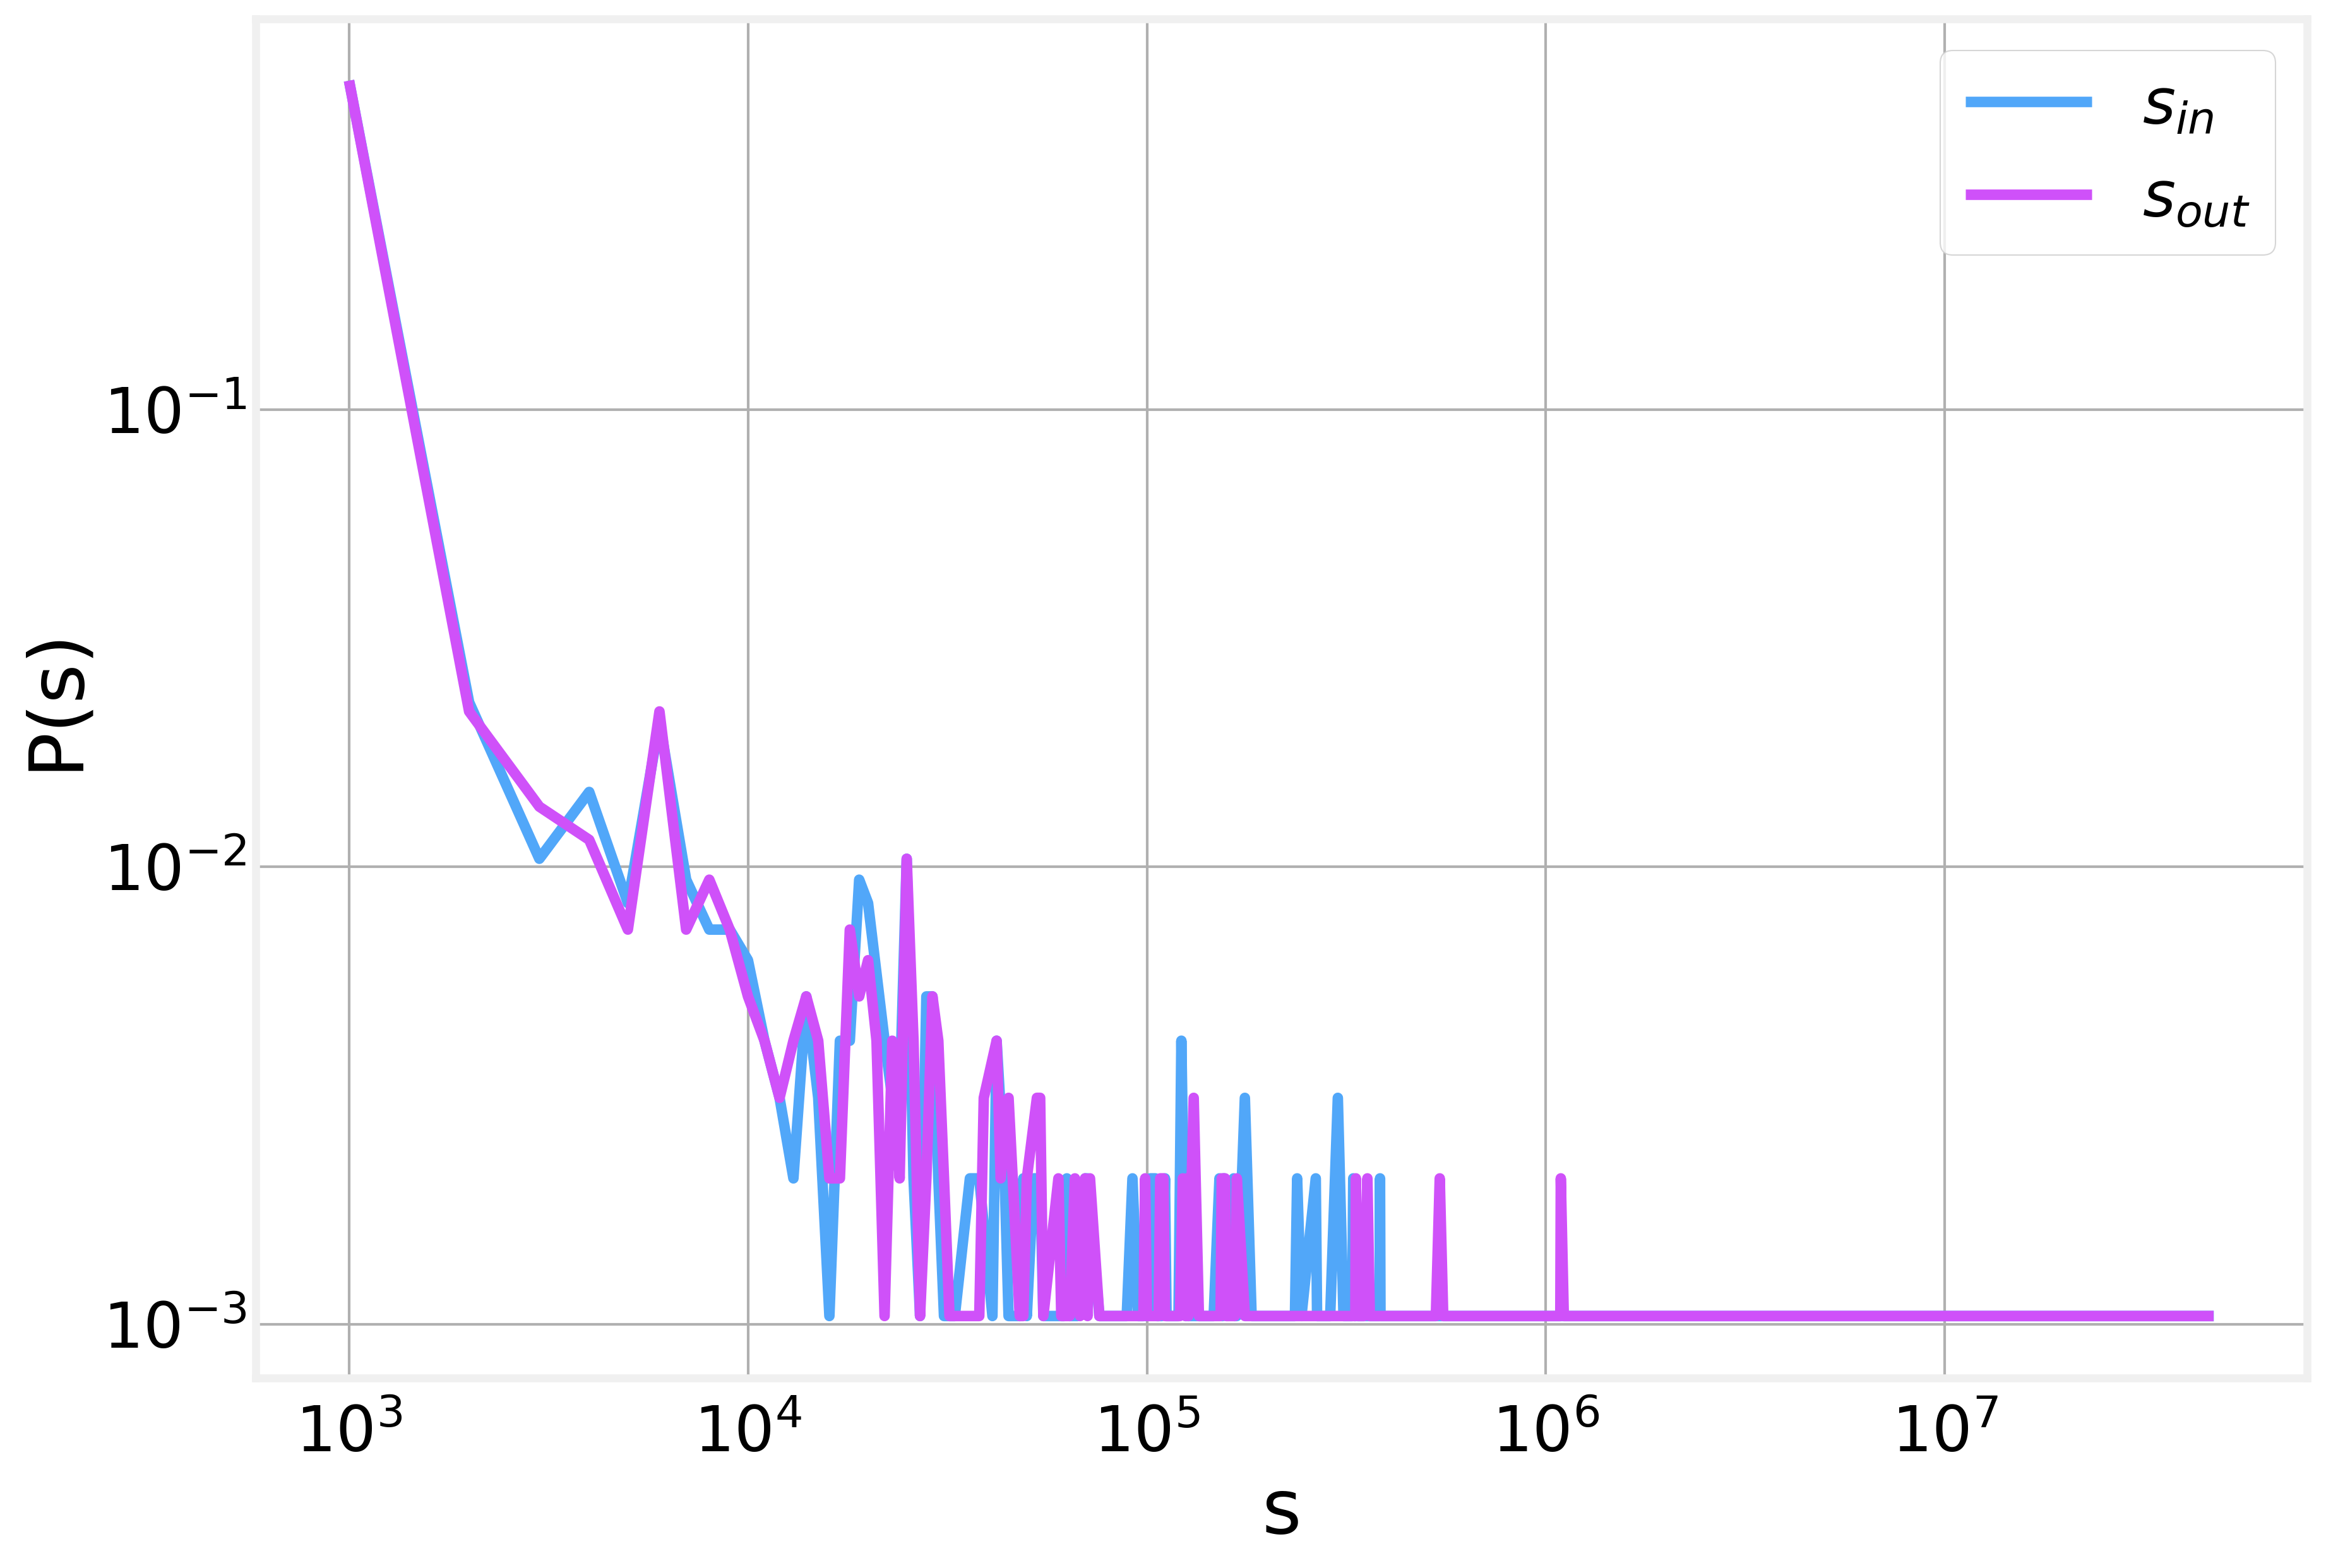

In [49]:
ax = PSin.plot()
PSout.plot(ax=ax)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('s')
ax.set_ylabel('P(s)')
ax.legend(['$s_{in}$', '$s_{out}$'])
ax.tick_params(axis='x', which='major', pad=10)
plt.tight_layout()

Text(0, 0.5, '$s_{in}$')

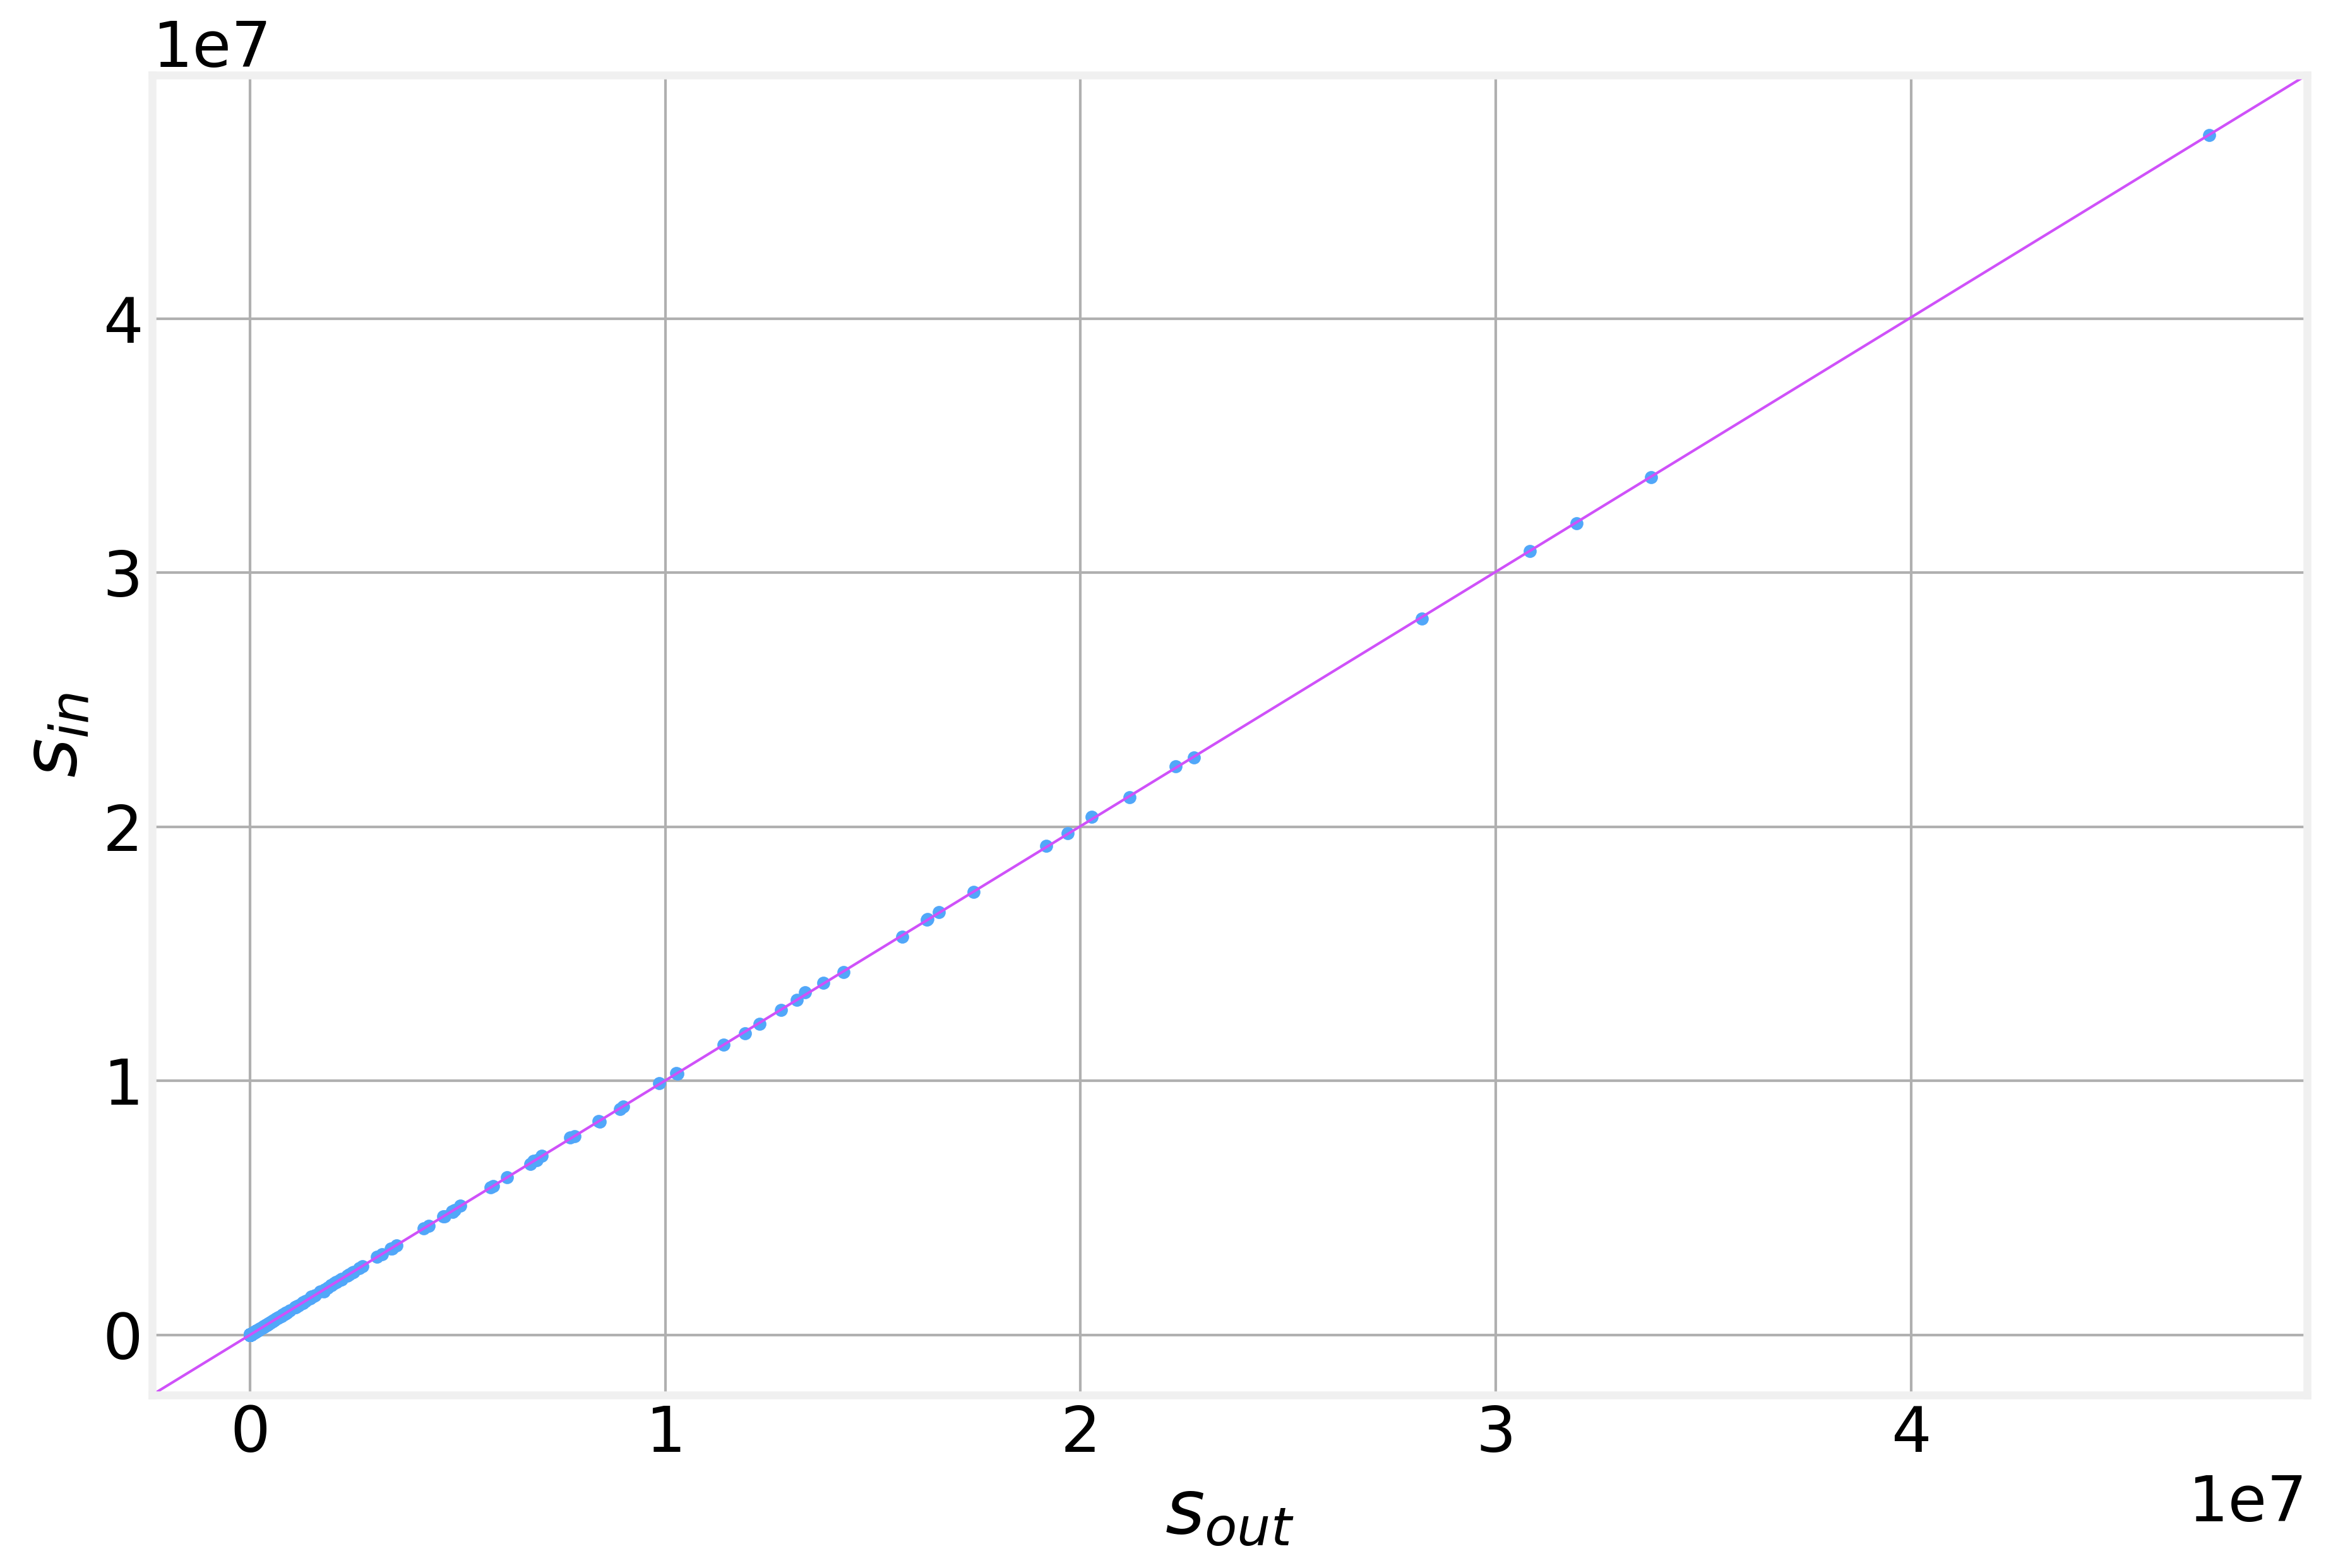

In [50]:
ax = in_out.plot.scatter(x='sout', y='sin')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=1, color=colors[1])
ax.set_xlabel('$s_{out}$')
ax.set_ylabel('$s_{in}$')

Text(0, 0.5, '$s$')

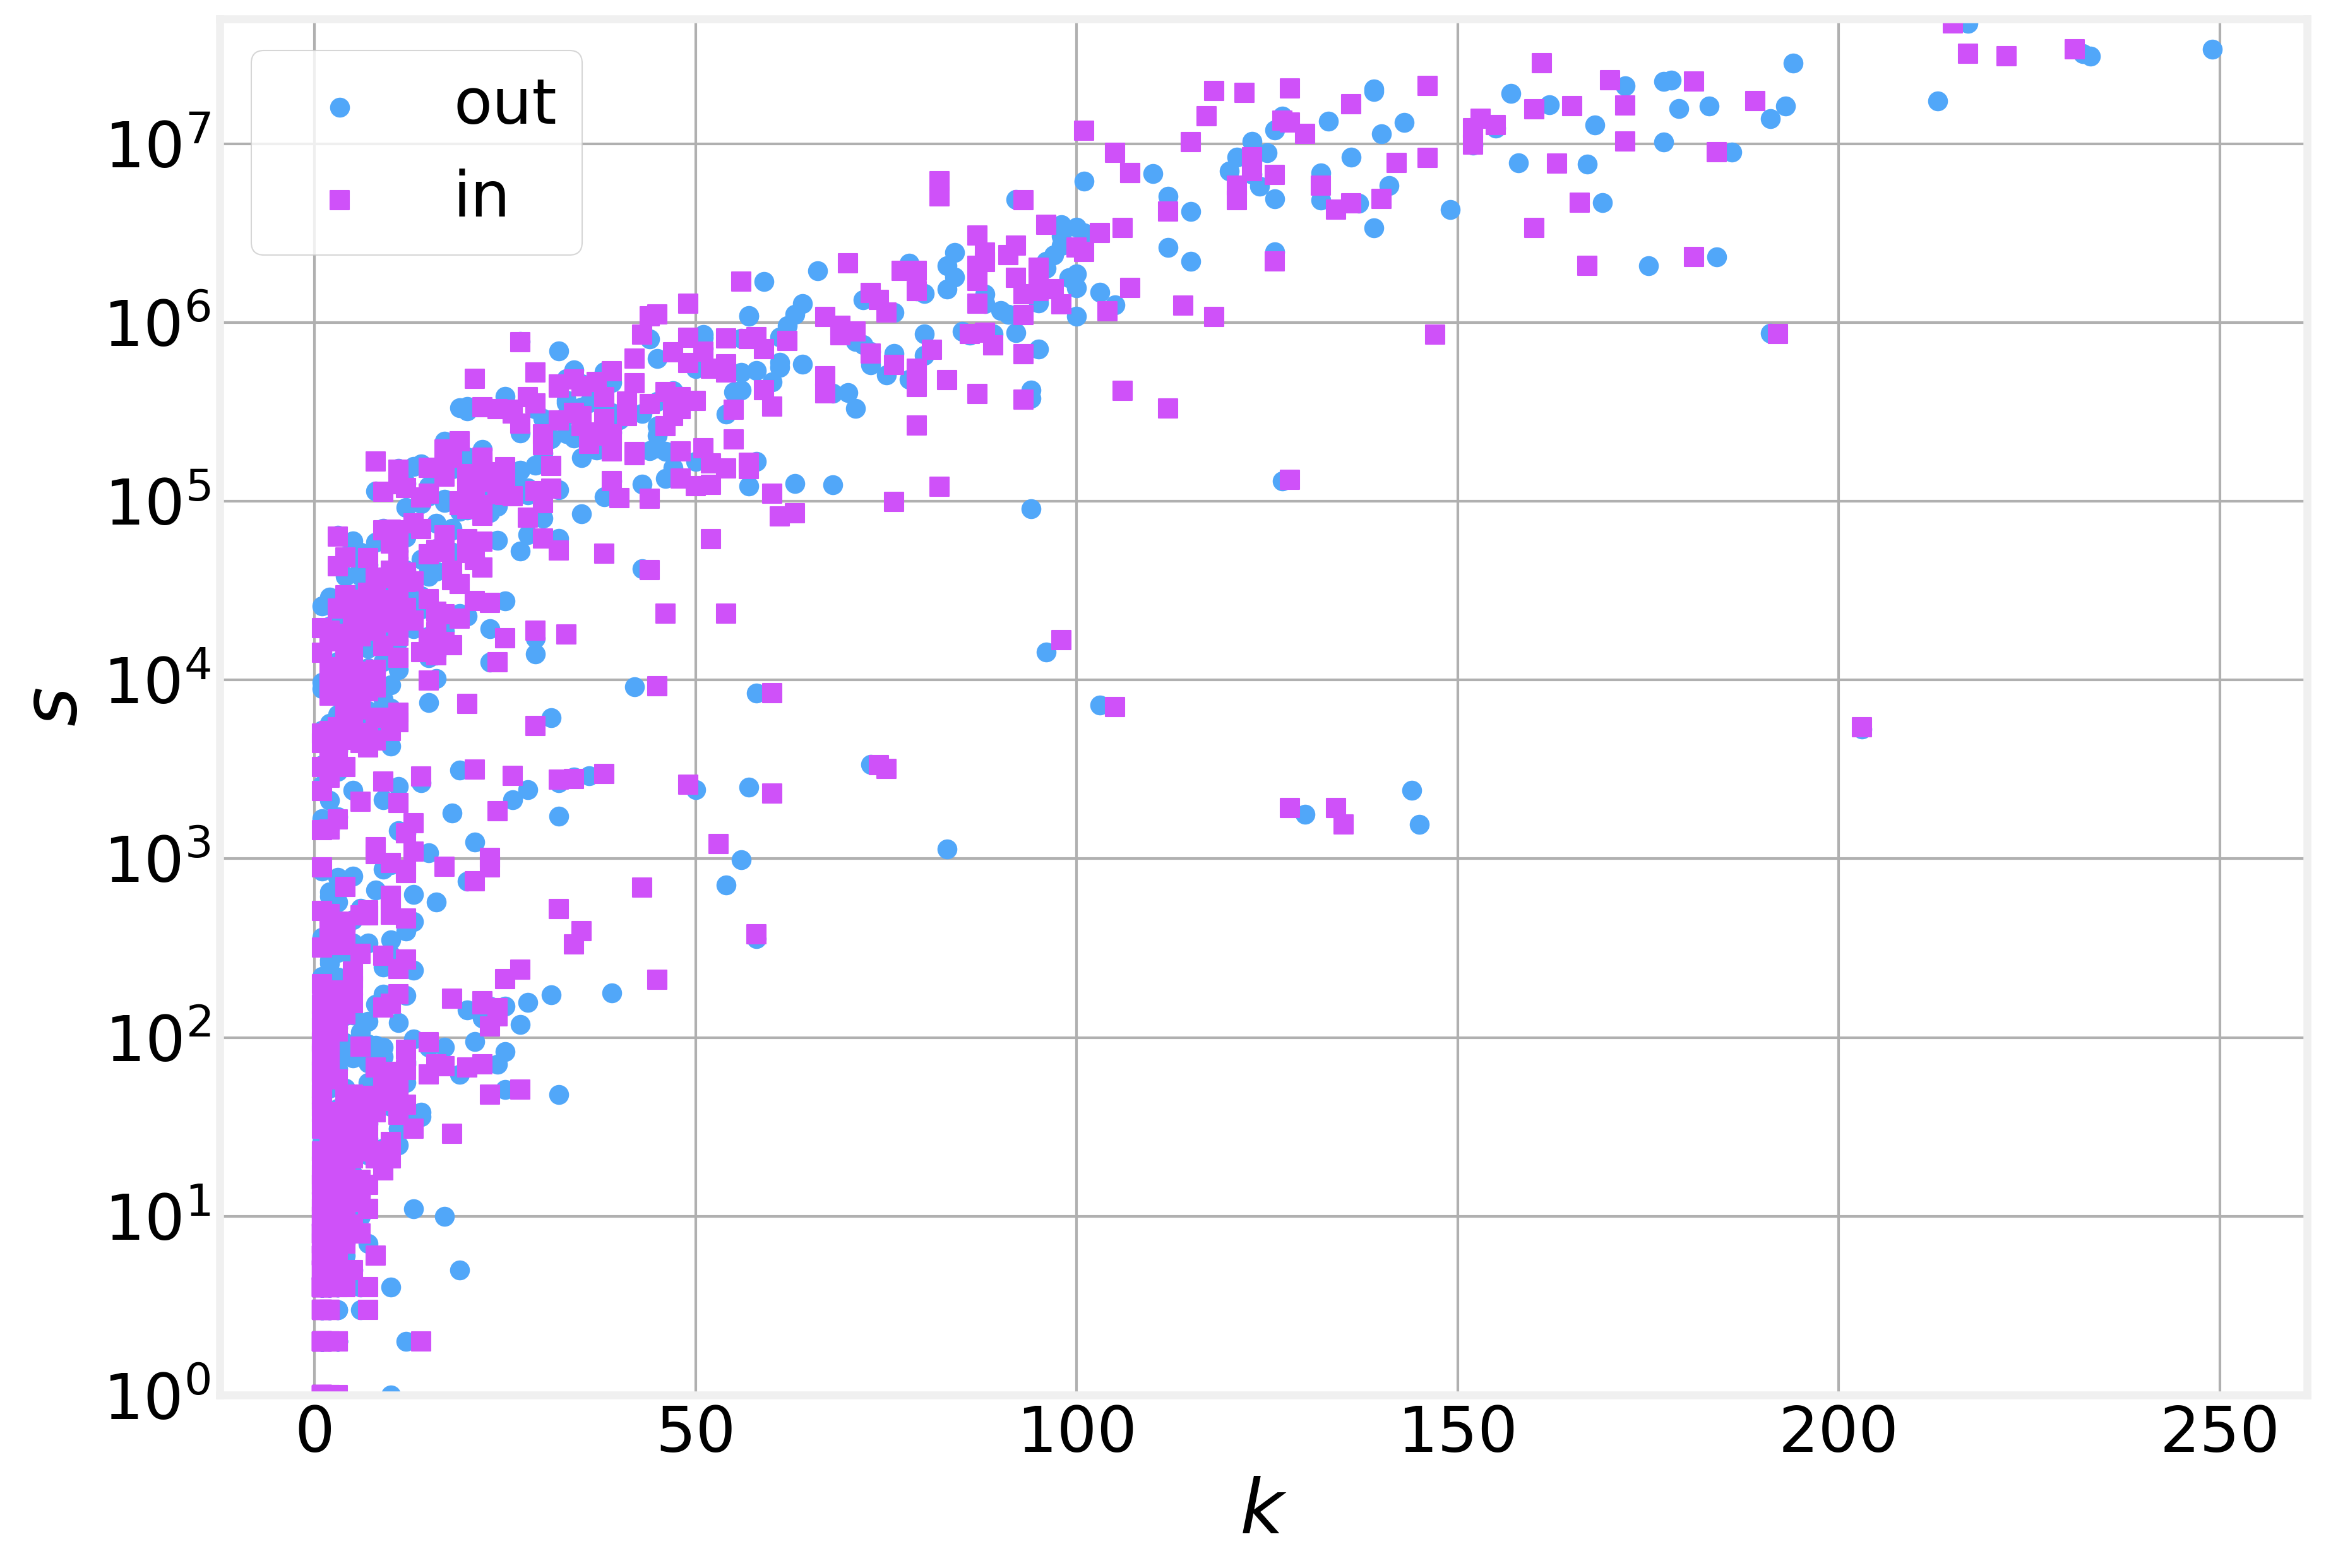

In [51]:
ax = in_out.plot.scatter(x='kout', y='sout', color=colors[0], s=50, label='out')
in_out.plot.scatter(x='kin', y='sin', ax=ax, color=colors[1], s=50, marker='s', label='in')
ax.set_yscale('log')
ax.set_ylim(1, 5e7)
ax.set_xlabel('$k$')
ax.set_ylabel('$s$')

<div style="width: 100%; overflow: hidden;">
     <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>